In [6]:
import torch
import numpy as np
from scipy.optimize import minimize_scalar

###############################################################################
# 0. 全体設定
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print("使用デバイス:", device)

n = 8            # 消費者が使用する期間           
aU = 0.7           # 中古品の満足度の割引率
aS = 0.95           # サブスクリプションの満足度の割引率
cN = 0.5           # 新品のコスト
cU = 0.3           # 中古品のコスト
cSub = 0.05        # サブスクリプションの毎期コスト
cSubF = 0.0        # サブスクリプションの固定コスト
R = 0.95            # サブスクの生産者の利益の割引率

price_min = 0.0    # 価格の下限
price_max = 1.0    # 価格の上限
num_samples = 500000  # 需要計算時のランダムサンプル数
max_iter = 400     # 反復回数の最大値
tol = 1e-3         # 収束の許容誤差

# r_min, r_max 定義
r_min = 0.5
r_max = 0.95

# 固定ランダムシード（再現性のため）
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

###############################################################################
# 1. 効用関数
###############################################################################
def u_new_torch(w, r, pN):
    if pN is None or pN<=0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n)/(1 - r_clamp)
    return w * term - pN

def u_used_torch(w, r, pU):
    if pU is None or pU<=0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n)/(1 - r_clamp)
    return aU * w * term - pU

def u_sub_torch(w, r, pSub):
    if pSub is None or pSub<=0:  # 不生产 => 效用视为负无穷
        return torch.full_like(w, -9999.0)
    eps = 1e-12
    r_clamp = torch.clamp(r, eps, 1 - eps)
    term = (1 - r_clamp**n)/(1 - r_clamp)
    return (aS * w - pSub) * term

###############################################################################
# 2. 需要関数 (不生产时需求=0)
###############################################################################
def demand_new(pN, pU, pSub):
    if pN is None or pN<=0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min)*torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un<0) & (uu<0) & (us<0)
    new_mask = (un >= uu) & (un >= us) & (~no_mask)
    return new_mask.float().mean().item()

def demand_used(pN, pU, pSub):
    if pU is None or pU<=0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min)*torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un<0) & (uu<0) & (us<0)
    used_mask = (uu >= un) & (uu >= us) & (~no_mask)
    return used_mask.float().mean().item()

def demand_sub(pN, pU, pSub):
    if pSub is None or pSub<=0:
        return 0.0
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min)*torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un<0) & (uu<0) & (us<0)
    sub_mask = (us >= un) & (us >= uu) & (~no_mask)
    return sub_mask.float().mean().item()

def demand_no(pN, pU, pSub):
    """
    不消費を選ぶ確率
    """
    w = torch.rand(num_samples, device=device)
    r = r_min + (r_max - r_min)*torch.rand(num_samples, device=device)

    un = u_new_torch(w, r, pN)
    uu = u_used_torch(w, r, pU)
    us = u_sub_torch(w, r, pSub)

    no_mask = (un < 0) & (uu < 0) & (us < 0)
    return no_mask.float().mean().item()

###############################################################################
# 3. 利潤関数: 若选择不生产 => 利润=0
###############################################################################
def profit_new(pN, pU, pSub):
    if pN is None or demand_new(pN, pU, pSub) == 0:
        return 0.0  # 不生产 => 利润=0
    dN = demand_new(pN, pU, pSub)
    return dN * (pN - cN)

def profit_used(pN, pU, pSub):
    if pU == float('inf') or demand_used(pN, pU, pSub) == 0:
        return 0  # 若退出市场或需求为0，利润直接为0
    dU = demand_used(pN, pU, pSub)
    return dU * (pU - cU)

def profit_sub(pN, pU, pSub):
    if pSub == float('inf') or demand_sub(pN, pU, pSub) == 0:
        return 0  # 若退出市场或需求为0，利润直接为0
    dS = demand_sub(pN, pU, pSub)
    discount_factor = (1 - R**n) / (1 - R) if abs(1 - R) > 1e-12 else n  # 避免分母为0
    return dS * (pSub - cSub) * discount_factor - cSubF

###############################################################################
# 4. 最適反応関数：若最大利润<0 => 不生产
###############################################################################
def best_response_new(pU, pS):
    """
    新品企業の最適価格を計算:
      - まず minimize_scalar で最大利潤を探索
      - その最大利潤が <= 0 の場合、不生産(価格=None, profit=0) とする
    """
    # 1) 先用 minimize_scalar 找到在 price_min..price_max 内最优价格
    res = minimize_scalar(
        lambda pN: -profit_new(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pN = res.x
    best_profit = -res.fun  # 最大化利润 => -res.fun

    # 2) 如果 best_profit <=0 => 不生产
    if best_profit <= 0:
        return None  # 用 None 表示不生产
    else:
        return best_pN

def best_response_used(pN, pS):
    res = minimize_scalar(
        lambda pU: -profit_used(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pU = res.x
    best_profit = -res.fun
    if best_profit <= 0:
        return None
    else:
        return best_pU

def best_response_sub(pN, pU):
    res = minimize_scalar(
        lambda pS: -profit_sub(pN, pU, pS),
        bounds=(price_min, price_max),
        method='bounded'
    )
    best_pS = res.x
    best_profit = -res.fun
    if best_profit <= 0:
        return None
    else:
        return best_pS

###############################################################################
# 5. 均衡価格の探索
###############################################################################
def find_equilibrium_prices(pN_init=0.7, pU_init=0.5, pS_init=0.3):
    """
    すべての企業が最適反応を繰り返し調整し、均衡価格を見つける。
    ただし、企業が最大利潤 <= 0 の場合、その企業の価格は "無限大" に設定され、市場から退出する。
    """
    alpha = 0.1  # 阻尼系数
    pN, pU, pS = pN_init, pU_init, pS_init

    for i in range(max_iter):
        oldN, oldU, oldS = pN, pU, pS

        # 计算各自最优反应价格
        new_pN = best_response_new(oldU, oldS)
        new_pU = best_response_used(new_pN, oldS)
        new_pS = best_response_sub(new_pN, new_pU)

        # 如果利润 <= 0，则退出市场（设为 float('inf')）
        if new_pN is None or profit_new(new_pN, oldU, oldS) <= 0:
            new_pN = float('inf')
        if new_pU is None or profit_used(oldN, new_pU, oldS) <= 0:
            new_pU = float('inf')
        if new_pS is None or profit_sub(oldN, oldU, new_pS) <= 0:
            new_pS = float('inf')

        # 更新价格（退出市场的价格不变，继续保持为 inf）
        pN = new_pN if new_pN == float('inf') else (alpha * new_pN + (1 - alpha) * oldN)
        pU = new_pU if new_pU == float('inf') else (alpha * new_pU + (1 - alpha) * oldU)
        pS = new_pS if new_pS == float('inf') else (alpha * new_pS + (1 - alpha) * oldS)

        # 计算更新距离，退出市场企业（inf）不参与距离计算
        dist = sum([
            ((pN - oldN)**2 if pN != float('inf') else 0),
            ((pU - oldU)**2 if pU != float('inf') else 0),
            ((pS - oldS)**2 if pS != float('inf') else 0)
        ])**0.5

        if dist < tol:
            print(f"収束した (Iter {i+1})")
            return pN, pU, pS

    print(f"警告: {max_iter}回に達しましたが収束しません。")
    print(f"最終: pN={pN}, pU={pU}, pS={pS}")
    return pN, pU, pS

###############################################################################
# 6. 需要と利潤の表示
###############################################################################
def show_demands_and_profits(pN, pU, pS):
    """
    各企業の需要量と利潤を表示する
    """
    dN = demand_new(pN, pU, pS)
    dU = demand_used(pN, pU, pS)
    dS = demand_sub(pN, pU, pS)
    dNo = demand_no(pN, pU, pS)

    piN = profit_new(pN, pU, pS)
    piU = profit_used(pN, pU, pS)
    piS = profit_sub(pN, pU, pS)

    print("需要量:")
    print(f"  D_new  = {dN:.4f}")
    print(f"  D_used = {dU:.4f}")
    print(f"  D_sub  = {dS:.4f}")
    print(f"  D_no   = {dNo:.4f}")
    print(f"  合計    = {dN + dU + dS + dNo:.4f}")

    print("利潤:")
    print(f"  profit_new  = {piN:.4f}")
    print(f"  profit_used = {piU:.4f}")
    print(f"  profit_sub  = {piS:.4f}")

In [7]:
# 7. 選択分布の可視化
###############################################################################
def plot_choice_regions(pN, pU, pS):
    """
    (w, r)平面における消費者の選択分布をプロット (No Consumption対応版)
    4カテゴリ: 0=New, 1=Used, 2=Sub, 3=No
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # ▼ スタイル設定
    mpl.rcParams.update({
        'font.size': 8,
        'font.family': 'sans-serif',
        'axes.linewidth': 0.6,
        'axes.labelsize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'xtick.major.size': 3,
        'ytick.major.size': 3,
        'figure.dpi': 300,
        'figure.figsize': (3.2, 2.4),
    })

    # グリッド生成
    Ngrid = 200
    w_vals = torch.linspace(0, 1, Ngrid, device=device)  # w の範囲 [0, 1]
    r_vals = torch.linspace(r_min, r_max, Ngrid, device=device)  # r の範囲 [r_min, r_max]
    W, R_ = torch.meshgrid(w_vals, r_vals)

    # 3種の効用を計算
    Un = u_new_torch(W, R_, pN)
    Uu = u_used_torch(W, R_, pU)
    Us = u_sub_torch(W, R_, pS)

    # (0=New, 1=Used, 2=Sub) の最大効用を取得
    allU = torch.stack([Un, Uu, Us], dim=0)
    cat_map = torch.argmax(allU, dim=0)  # shape=(Ngrid, Ngrid)

    # 不消費判定
    no_mask = (Un < 0) & (Uu < 0) & (Us < 0)
    cat_map = cat_map.clone()
    cat_map[no_mask] = 3  # 3 => No Consumption

    # 離散色マップ(4カテゴリ)
    cmap = mcolors.ListedColormap(['#66c2a5', '#fc8d62', '#8da0cb', '#aaaaaa'])
    norm = mcolors.BoundaryNorm([0, 1, 2, 3, 4], cmap.N)

    fig, ax = plt.subplots()
    mesh = ax.pcolormesh(
        W.cpu().numpy(), R_.cpu().numpy(),
        cat_map.cpu().numpy(),
        cmap=cmap, norm=norm, shading='nearest'
    )

    # ▼ ラベルを領域内に配置: 座標微調整
    ax.text(0.8, r_min + 0.75 * (r_max - r_min), 'New', fontsize=8, color='black',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.text(0.2, r_min + 0.75 * (r_max - r_min), 'Used', fontsize=8, color='black',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.text(0.5, r_min + 0.55 * (r_max - r_min), 'Sub', fontsize=8, color='black',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
    ax.text(0.1, r_min + 0.2 * (r_max - r_min), 'No', fontsize=8, color='black',
            ha='center', va='center',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

    # 軸ラベル・範囲0-1のみ
    ax.set_xlabel('w (Value Perception)', fontsize=9)
    ax.set_ylabel('r (Discount Rate)', fontsize=9)
    ax.set_xlim(0, 1)
    ax.set_ylim(r_min, r_max)
    ax.set_xticks([0, 1])
    ax.set_yticks([r_min, r_max])

    ax.set_aspect('equal', adjustable='box')

    plt.tight_layout()
    plt.show()


def sweep_param_and_plot(param_name, start_val, end_val, steps=None, plot_prices=True, plot_demands=True, plot_profits=True):
    """
    特定の外生パラメータ (param_name) を指定範囲で変化させ、
    各値に対する均衡価格 (pN, pU, pS)、需要 (D_new, D_used, D_sub)、
    および利潤 (profit_new, profit_used, profit_sub) を計算してプロット。

    引数:
      param_name (str): スキャン対象の外生パラメータ名 ("aU", "n", "R"など)。
      start_val  (float|int): パラメータの開始値。
      end_val    (float|int): パラメータの終了値。
      steps      (int|None): パラメータのステップ数（整数の場合は無視される）。
      plot_prices (bool): 均衡価格をプロットするか。
      plot_demands (bool): 需要シェアをプロットするか。
      plot_profits (bool): 利潤をプロットするか。
    """
    import matplotlib.pyplot as plt
    
    # まずグローバル変数を取り扱う
    global aU, n, R  # 必要に応じて追加
    
    # 取り扱い対象のパラメータを取得
    original_value = None
    if param_name == "aU":
        original_value = aU
    elif param_name == "n":
        original_value = n
    elif param_name == "R":
        original_value = R
    else:
        raise ValueError(f"不明なパラメータ名: {param_name}")
    
    # 整数範囲の場合はステップ数を無視してリスト生成
    if param_name == "n":
        param_values = list(range(int(start_val), int(end_val) + 1))
    else:
        # 通常の等間隔リスト生成
        param_values = np.linspace(start_val, end_val, steps)

    # 結果格納用リスト
    pN_list, pU_list, pS_list = [], [], []
    dN_list, dU_list, dS_list, dNo_list = [], [], [], []
    piN_list, piU_list, piS_list = [], [], []
    
    for val in param_values:
        # 対応するパラメータを設定
        if param_name == "aU":
            aU = val
        elif param_name == "n":
            n = val
        elif param_name == "R":
            R = val
        
        # 均衡価格計算
        pN_star, pU_star, pS_star = find_equilibrium_prices()
        
        # 需要と利潤計算
        dN = demand_new(pN_star, pU_star, pS_star)
        dU = demand_used(pN_star, pU_star, pS_star)
        dS = demand_sub(pN_star, pU_star, pS_star)
        dNo = demand_no(pN_star, pU_star, pS_star)
        
        piN = profit_new(pN_star, pU_star, pS_star)
        piU = profit_used(pN_star, pU_star, pS_star)
        piS = profit_sub(pN_star, pU_star, pS_star)
        
        # リストに記録
        pN_list.append(pN_star)
        pU_list.append(pU_star)
        pS_list.append(pS_star)
        
        dN_list.append(dN)
        dU_list.append(dU)
        dS_list.append(dS)
        dNo_list.append(dNo)
        
        piN_list.append(piN)
        piU_list.append(piU)
        piS_list.append(piS)
    
    # 元のパラメータ値を復元
    if param_name == "aU":
        aU = original_value
    elif param_name == "n":
        n = original_value
    elif param_name == "R":
        R = original_value
    
    # グラフ描画
    nrows = sum([plot_prices, plot_demands, plot_profits])
    fig, axes = plt.subplots(nrows=nrows, ncols=1, figsize=(6, 4 * nrows), dpi=120)
    
    if nrows == 1:
        axes = [axes]  # リストに変換
    
    plot_index = 0
    
    # 均衡価格のプロット
    if plot_prices:
        ax = axes[plot_index]
        ax.plot(param_values, pN_list, marker='o', label="pN (New)", color="#66c2a5")
        ax.plot(param_values, pU_list, marker='s', label="pU (Used)", color="#fc8d62")
        ax.plot(param_values, pS_list, marker='^', label="pS (Sub)", color="#8da0cb")
        ax.set_xlabel(param_name)
        ax.set_ylabel("Price")
        ax.set_title("Equilibrium Prices vs. " + param_name)
        ax.grid(True)
        ax.legend()
        plot_index += 1
    
    # 需要のプロット
    if plot_demands:
        ax = axes[plot_index]
        ax.plot(param_values, dN_list, marker='o', label="D_new", color="#66c2a5")
        ax.plot(param_values, dU_list, marker='s', label="D_used", color="#fc8d62")
        ax.plot(param_values, dS_list, marker='^', label="D_sub", color="#8da0cb")
        ax.plot(param_values, dNo_list, marker='x', label="D_no", color="#aaaaaa")
        ax.set_xlabel(param_name)
        ax.set_ylabel("Demand share")
        ax.set_title("Demand vs. " + param_name)
        ax.grid(True)
        ax.legend()
        plot_index += 1
    
    # 利潤のプロット
    if plot_profits:
        ax = axes[plot_index]
        ax.plot(param_values, piN_list, marker='o', label="profit_new", color="#66c2a5")
        ax.plot(param_values, piU_list, marker='s', label="profit_used", color="#fc8d62")
        ax.plot(param_values, piS_list, marker='^', label="profit_sub", color="#8da0cb")
        ax.set_xlabel(param_name)
        ax.set_ylabel("Profit")
        ax.set_title("Profit vs. " + param_name)
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

収束した (Iter 31)

最終均衡価格: pN=0.8552, pU=0.4233, pS=0.1870
需要量:
  D_new  = 0.2771
  D_used = 0.0774
  D_sub  = 0.4825
  D_no   = 0.1628
  合計    = 0.9998
利潤:
  profit_new  = 0.0978
  profit_used = 0.0096
  profit_sub  = 0.4433


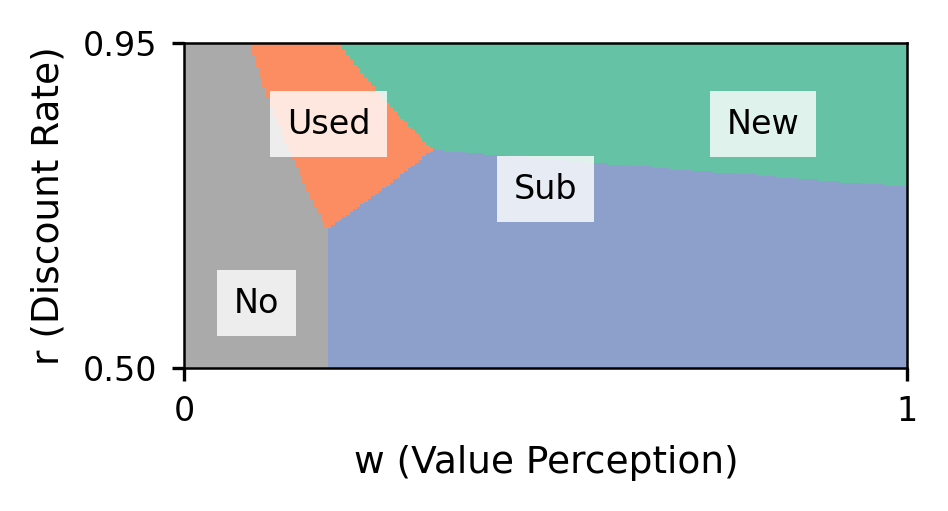

収束した (Iter 22)
収束した (Iter 28)
収束した (Iter 34)
収束した (Iter 43)
収束した (Iter 30)
収束した (Iter 33)
収束した (Iter 31)


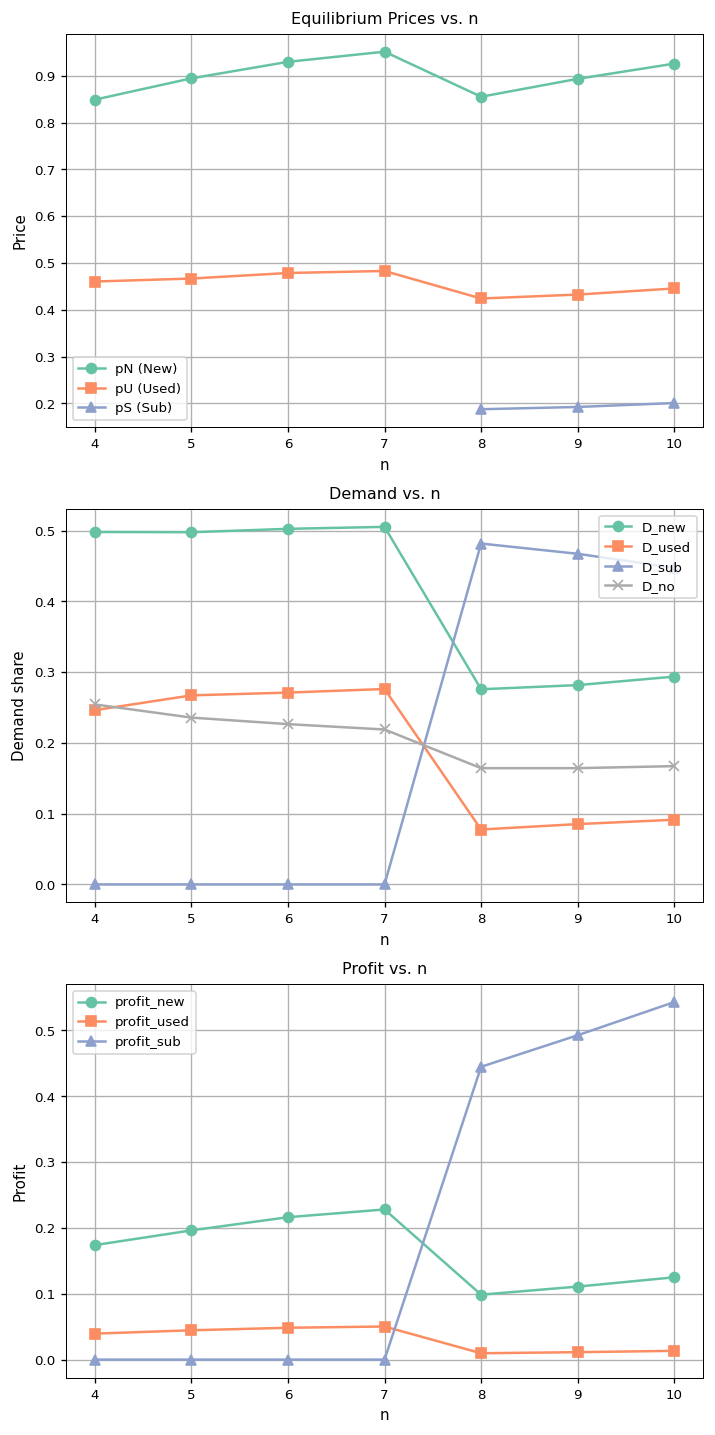

In [8]:
###############################################################################
# 8. メインプログラム
###############################################################################
if __name__ == "__main__":
    # 1) 均衡価格を求める
    pN_star, pU_star, pS_star = find_equilibrium_prices()
    print(f"\n最終均衡価格: pN={pN_star:.4f}, pU={pU_star:.4f}, pS={pS_star:.4f}")

    # 2) 需要と利潤を表示
    show_demands_and_profits(pN_star, pU_star, pS_star)

    # 3) 選択分布をプロット
    plot_choice_regions(pN_star, pU_star, pS_star)

    # 例: aUを0.2から0.8までステップ5でスキャンし、価格・需要・利益のグラフを作る
    #sweep_param_and_plot(param_name="aU", start_val=0.2, end_val=0.8, steps=5,
    #                 plot_prices=True, plot_demands=True, plot_profits=True)

    # 同様に n をスキャンする場合の例:
    sweep_param_and_plot(param_name="n", start_val=4, end_val=10, steps=7)

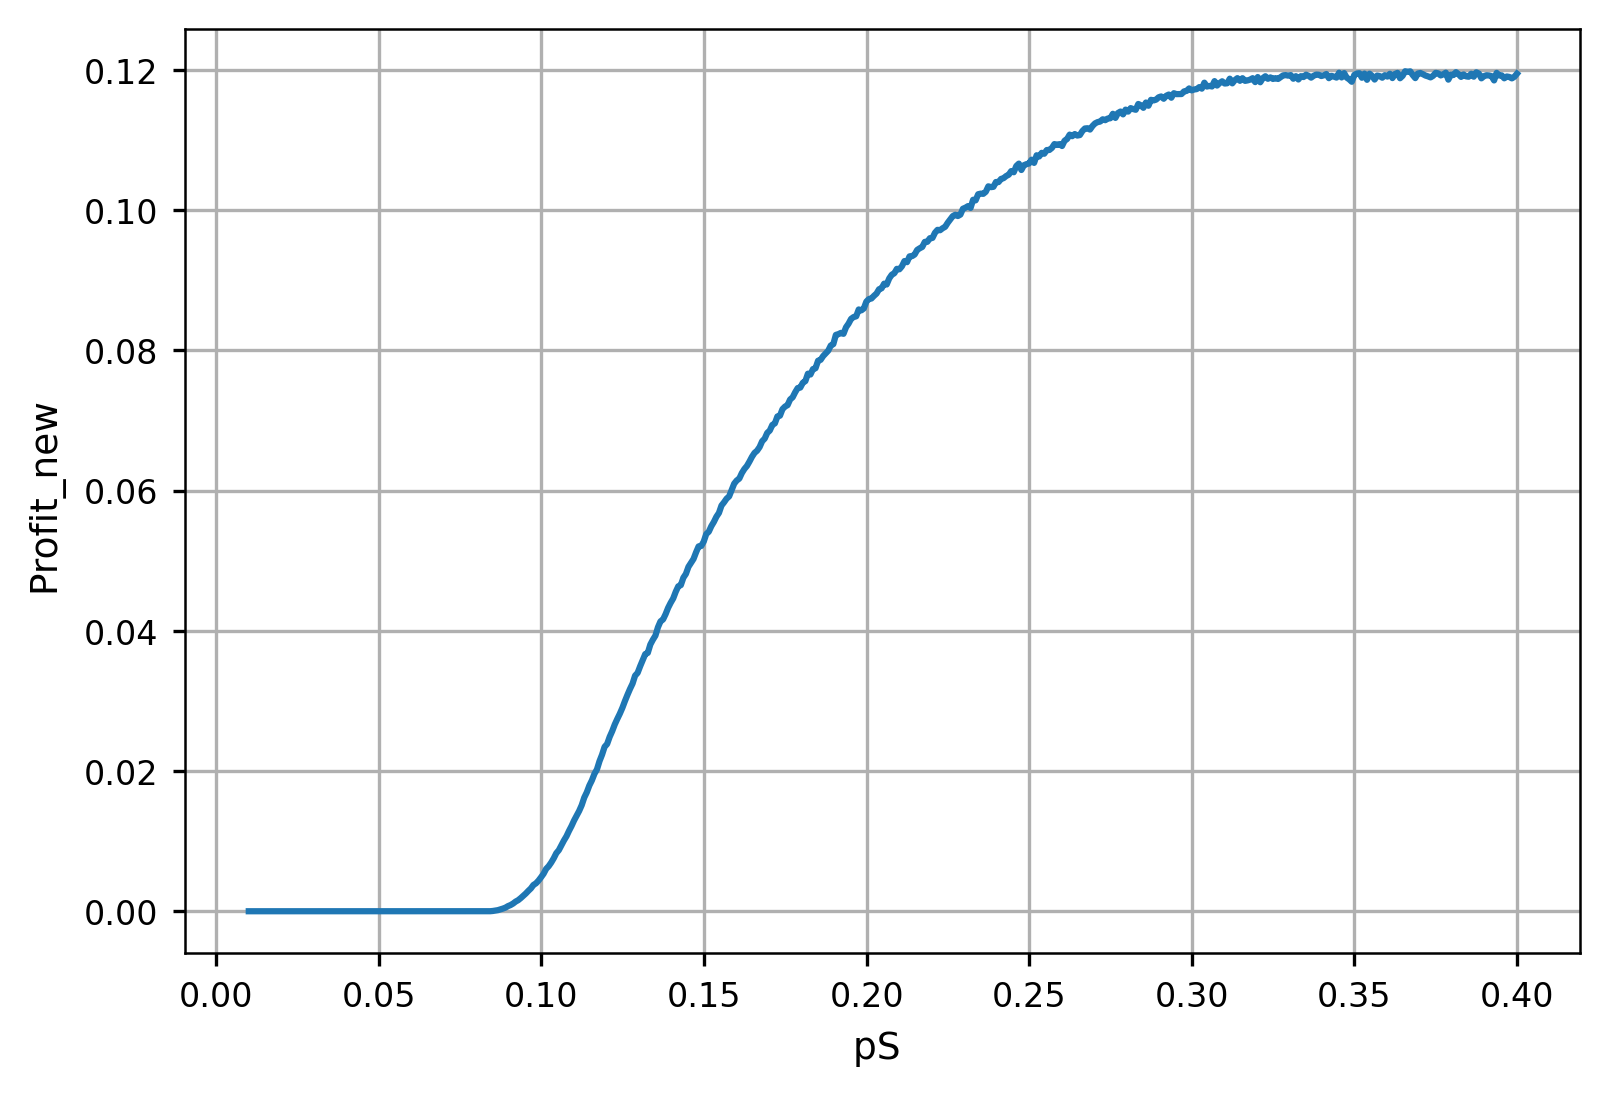

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_dN_vs_pS(pN_fixed=0.89, pU_fixed=0.429, pS_start=0.01, pS_end=0.4, num_points=500):
    """
    pN_fixed:  固定的新产品价格
    pU_fixed:  固定的二手产品价格
    pS_start:  pS 取值的起始
    pS_end:    pS 取值的终止
    num_points: 取点数量
    """
    pS_values = np.linspace(pS_start, pS_end, num_points)
    figure_values = []

    for pS in pS_values:
        figN = profit_new(pN_fixed, pU_fixed, pS)
        figure_values.append(figN)

    plt.figure(figsize=(6,4))
    plt.plot(pS_values, figure_values, marker='', linestyle='-')
    plt.xlabel("pS ")
    plt.ylabel("Profit_new ")
    #plt.title(f" D_new and pS\n(pN={pN_fixed}, pU={pU_fixed})")
    plt.grid(True)
    plt.show()

# 例: 在主程序最后添加并调用
if __name__ == "__main__":
    pN_init = 0.9
    pU_init = 0.2
    plot_dN_vs_pS(pN_fixed=pN_init, pU_fixed=pU_init)